In [25]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader

In [26]:
batch_size = 64
img_size = 28
patch_size = 7
num_channels = 1
num_patches = (img_size//patch_size)**2
num_heads = 1
embed_dim = 16
mlp_dim = 16
transformer_units = 1

transform = transforms.Compose(
    [transforms.ToTensor()]
)

In [27]:
train_set =  torchvision.datasets.MNIST(root = "./data",train = True,download = True,transform = transform)
val_set =  torchvision.datasets.MNIST(root = "./data",train = False,download = True,transform = transform)

In [28]:
train_data = DataLoader(train_set,batch_size=batch_size,shuffle=True)
val_data = DataLoader(val_set,batch_size=batch_size,shuffle=False)

In [ ]:
from huggingface_hub import PyTorchModelHubMixin

class PatchEmbedding(nn.Module,PyTorchModelHubMixin):
  def __init__(self):
    super().__init__()
    self.patch_embed = nn.Conv2d(num_channels,embed_dim, kernel_size=patch_size,stride = patch_size)

  def forward(self,x):
    x = self.patch_embed(x)
    x = x.flatten(2)
    x = x.transpose(1,2)
    return x

In [ ]:

class TransformerArchitecture(nn.Module,PyTorchModelHubMixin):
  def __init__(self):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(embed_dim)
    self.self_attention = nn.MultiheadAttention(embed_dim,num_heads,batch_first = True)
    self.layer_norm2 = nn.LayerNorm(embed_dim)
    self.multi_layer_preceptron = nn.Sequential(
        nn.Linear(embed_dim,mlp_dim),
        nn.GELU(),
        nn.Linear(mlp_dim,embed_dim)
    )

  def forward(self,x):
    residual_1 = x
    attention_output = self.self_attention(self.layer_norm1(x),self.layer_norm1(x),self.layer_norm1(x))[0]
    x = attention_output + residual_1
    residual_2 = x
    mlp_output = self.multi_layer_preceptron(self.layer_norm2(x))
    x = mlp_output + residual_2
    return x

In [31]:

class VisionTransformer(nn.Module, PyTorchModelHubMixin):
  def __init__(self):
    super().__init__()
    self.patch_embedding = PatchEmbedding()
    self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
    self.pos_embed = nn.Parameter(torch.randn(1,(img_size//patch_size)**2 + 1, embed_dim))
    self.transformer_layers = nn.Sequential(
        *[TransformerArchitecture() for _ in range(transformer_units)]
    )

    self.mlp_head = nn.Sequential(
        nn.LayerNorm(embed_dim),
        nn.Linear(embed_dim,10)
    )

  def forward(self,x):
    x = self.patch_embedding(x)
    B = x.size(0)

    cls_tokens = self.cls_token.expand(B,-1,-1)
    x = torch.cat((cls_tokens,x),dim=1)
    x = x + self.pos_embed
    x = self.transformer_layers(x)
    x = x[:,0]
    x = self.mlp_head(x)
    return x

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()

In [33]:
for epoch in range(10):
  model.train()
  total_loss = 0
  correct_epoch = 0
  total_epoch = 0
  print(f"Epoch : {epoch+1}")

  for batch_idx, (images,labels) in enumerate(train_data):
    images,labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)

    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    preds = outputs.argmax(dim=1)

    correct = (preds==labels).sum().item()
    accuracy = 100.0 * correct / labels.size(0)

    correct_epoch += correct
    total_epoch += labels.size(0)

    if batch_idx%100==0:
      print(f"Batch {batch_idx+1} : Loss = {loss.item():.4f}, Accuracy : {accuracy:.2f}")
  epoch_acc = 100.0 * correct_epoch /total_epoch
  print(f"Epoch {epoch+1}  Summary : Total Loss : {total_loss:.4f}, Accuracy = {epoch_acc:.2f}")






Epoch : 1
Batch 1 : Loss = 2.3197, Accuracy : 15.62
Batch 101 : Loss = 1.1986, Accuracy : 56.25
Batch 201 : Loss = 0.7966, Accuracy : 68.75
Batch 301 : Loss = 1.0729, Accuracy : 67.19
Batch 401 : Loss = 0.6797, Accuracy : 76.56
Batch 501 : Loss = 0.7255, Accuracy : 76.56
Batch 601 : Loss = 0.9511, Accuracy : 68.75
Batch 701 : Loss = 0.6349, Accuracy : 76.56
Batch 801 : Loss = 0.7244, Accuracy : 84.38
Batch 901 : Loss = 0.6145, Accuracy : 82.81
Epoch 1  Summary : Total Loss : 833.1008, Accuracy = 70.34
Epoch : 2
Batch 1 : Loss = 1.0220, Accuracy : 73.44
Batch 101 : Loss = 0.6073, Accuracy : 79.69
Batch 201 : Loss = 0.3909, Accuracy : 82.81
Batch 301 : Loss = 0.7725, Accuracy : 84.38
Batch 401 : Loss = 0.6477, Accuracy : 82.81
Batch 501 : Loss = 0.7267, Accuracy : 82.81
Batch 601 : Loss = 0.3976, Accuracy : 87.50
Batch 701 : Loss = 0.5602, Accuracy : 81.25
Batch 801 : Loss = 0.5742, Accuracy : 85.94
Batch 901 : Loss = 0.6109, Accuracy : 84.38
Epoch 2  Summary : Total Loss : 522.3222, Acc

In [34]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images,labels in val_data:
    images, labels = images.to(device) , labels.to(device)
    outputs = model(images)
    preds = outputs.argmax(dim=1)
    correct += (preds==labels).sum().item()
    total += labels.size(0)
  val_acc = 100.0 * correct/total
  print(f"Validation Accuracy: { val_acc:.2f}")



Validation Accuracy: 89.31


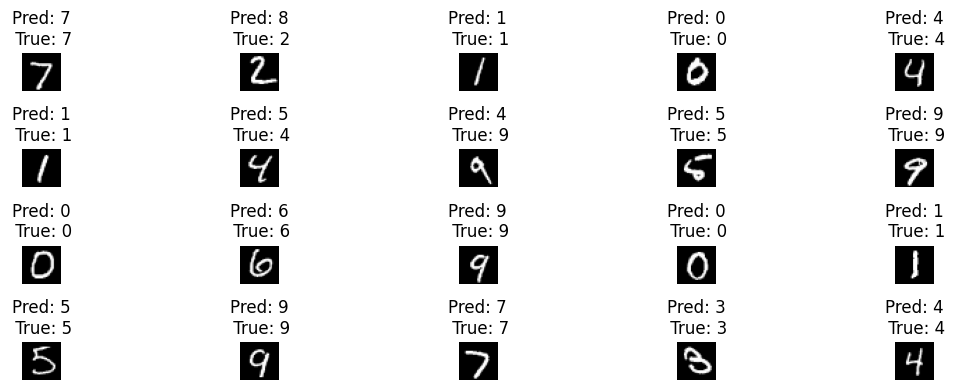

In [35]:
model.eval()
images , labels = next(iter(val_data))
images, labels = images.to(device) , labels.to(device)

with torch.no_grad():
  outputs = model(images)
  preds = outputs.argmax(dim=1)


plt.figure(figsize = (12,4))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(images[i].squeeze(),cmap = "grey")
  plt.title(f"Pred: {preds[i].item()}\n True: {labels[i].item()}")
  plt.axis("off")
plt.tight_layout()
plt.show()

In [36]:
# Manual Checking of Image Transformations in the Vision transformer

images , labels= next(iter(val_data))
print(f"Shape of the image data in batch : {images.shape}")
patch_embed = nn.Conv2d(num_channels,embed_dim,kernel_size=patch_size,stride = patch_size)
embedded_data = patch_embed(images)
embedded_data = embedded_data.flatten(2)
embedded_data = embedded_data.transpose(1,2)
print(f"shape of Embedded Data:  {embedded_data.shape}")
print(torch.randn(1,1,embed_dim).shape)

Shape of the image data in batch : torch.Size([64, 1, 28, 28])
shape of Embedded Data:  torch.Size([64, 16, 16])
torch.Size([1, 1, 16])


In [37]:
print(f"Batch Size: {batch_size}")
print(f"Image Size: {img_size}")
print(f"Patch Size: {patch_size}")
print(f"Number of Channels: {num_channels}")
print(f"Number of Patches: {num_patches}")
print(f"Number of Heads: {num_heads}")
print(f"Embedding Dimension: {embed_dim}")
print(f"MLP Dimension: {mlp_dim}")
print(f"Number of Transformer Units: {transformer_units}")

Batch Size: 64
Image Size: 28
Patch Size: 7
Number of Channels: 1
Number of Patches: 16
Number of Heads: 1
Embedding Dimension: 16
MLP Dimension: 16
Number of Transformer Units: 1


In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()

In [40]:
# repo_id = "Parthiban007/VisionTransformer"

# model.push_to_hub(repo_id)

# print(f"Model successfully pushed to https://huggingface.co/{repo_id}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

Model successfully pushed to https://huggingface.co/Parthiban007/VisionTransformer
